# NLP Project

## Section 1: Getting Familiar with the Dataset
### Read in semi-structured text data from a dataset obtained from UCI Machine Learning Repository

In [2]:
# Read in the raw text
rawData = open("SMSSpamCollection.tsv").read()

# Print the raw data
rawData[0:500]

"ham\tI've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.\nspam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\nham\tNah I don't think he goes to usf, he lives around here though\nham\tEven my brother is not like to speak with me. They treat me like aid"

In [3]:
import pandas as pd
data = pd.read_csv('SMSSpamCollection.tsv', sep='\t', header=None)
data.columns = ['label', 'body_text']

data.head()

,label,body_text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [4]:
# What is the shape of the dataset?

print("Input data has {} rows and {} columns".format(len(data), len(data.columns)))

# How many spam/ham are there?

print("Out of {} rows, {} are spam, {} are ham".format(len(data),
                                                       len(data[data['label']=='spam']),
                                                       len(data[data['label']=='ham'])))
# How much missing data is there?

print("Number of null in label: {}".format(data['label'].isnull().sum()))
print("Number of null in text: {}".format(data['body_text'].isnull().sum()))

Input data has 5568 rows and 2 columns
Out of 5568 rows, 746 are spam, 4822 are ham
Number of null in label: 0
Number of null in text: 0


## Section 2: Feature Engineering: adding Features to the data
_later on we will clean the text and remove punctuation from it. However, these pieces of information may be helpful for our spam filter somehow. Therefore, it would be efficient to analyze these feature before cleaning the data_ 

In [5]:
import string
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

data.head()

,label,body_text,body_len,punct%
0,ham,I've been searching for the right words to tha...,160,2.5
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1
3,ham,Even my brother is not like to speak with me. ...,62,3.2
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1


In [6]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

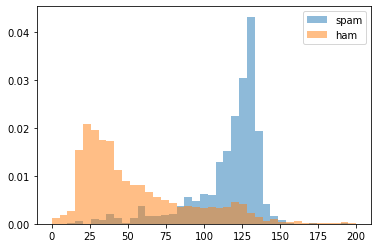

In [7]:
bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['label']=='spam']['body_len'], bins, alpha=0.5,density=True,stacked=True,  label='spam')
pyplot.hist(data[data['label']=='ham']['body_len'], bins, alpha=0.5,density=True,stacked=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

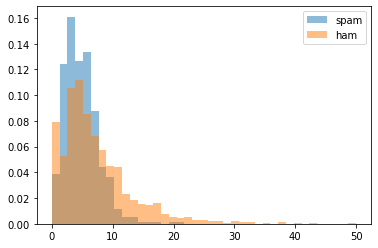

In [8]:
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['label']=='spam']['punct%'], bins, alpha=0.5, density=True,stacked=True, label='spam')
pyplot.hist(data[data['label']=='ham']['punct%'], bins, alpha=0.5, density=True,stacked=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

## Section 3: Text Analysis and Cleaning


In [9]:
import nltk
import re
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

data['body_text_clean'] = data['body_text'].apply(lambda x: clean_text(x.lower()))

data.head()

,label,body_text,body_len,punct%,body_text_clean
0,ham,I've been searching for the right words to tha...,160,2.5,"[ive, searching, right, words, thank, breather..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1,"[nah, dont, think, goes, usf, lives, around, t..."
3,ham,Even my brother is not like to speak with me. ...,62,3.2,"[even, brother, like, speak, treat, like, aids..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1,"[date, sunday]"


In [10]:
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

trial_data = pd.DataFrame()
trial_data['body_text_lemmatized'] = data['body_text_clean'].apply(lambda x: lemmatizing(x))
trial_data['body_text_stemmed'] = data['body_text_clean'].apply(lambda x: stemming(x))

trial_data.head()

,body_text_lemmatized,body_text_stemmed
0,"[ive, searching, right, word, thank, breather,...","[ive, search, right, word, thank, breather, pr..."
1,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
2,"[nah, dont, think, go, usf, life, around, though]","[nah, dont, think, goe, usf, live, around, tho..."
3,"[even, brother, like, speak, treat, like, aid,...","[even, brother, like, speak, treat, like, aid,..."
4,"[date, sunday]","[date, sunday]"


_from now on, we will move on with the limitizer instead of the stemmer since it makes smarter and more meaningful transformation to the vocabulary_

## Section 4: Data Preprocessing
### Method 1: Apply CountVectorizer

In [11]:
def analyze_text(text):
    return lemmatizing(clean_text(text))
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=analyze_text)
X_counts = count_vect.fit_transform(data['body_text'])
print(X_counts.shape)
X_counts

(5568, 11039)


<5568x11039 sparse matrix of type '<class 'numpy.int64'>'
	with 56278 stored elements in Compressed Sparse Row format>

### Vectorizers output sparse matrices

_**Sparse Matrix**: A matrix in which most entries are 0. In the interest of efficient storage, a sparse matrix will be stored by only storing the locations of the non-zero elements. We will use a dataframe instead to better represent the sparse matrix_

In [12]:
X_counts_feat = pd.DataFrame(X_counts.toarray())
X_counts_feat.columns = count_vect.get_feature_names()
X_counts_feat=pd.concat([data['body_len'], data['punct%'], X_counts_feat],axis =1)
X_counts_feat.head()

,body_len,punct%,,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,...,zero,zhong,zoom,zyada,Ü,Üll,é,ü,üll,〨ud
0,160,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,128,4.7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,49,4.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,62,3.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,7.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Method 2: Apply TF-IDF

Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=analyze_text)
X_tfidf = tfidf_vect.fit_transform(data['body_text'])
print(X_tfidf.shape)
X_tfidf


(5568, 11039)


<5568x11039 sparse matrix of type '<class 'numpy.float64'>'
	with 56278 stored elements in Compressed Sparse Row format>

In [14]:
X_tfidf_feat = pd.DataFrame(X_tfidf.toarray())
X_tfidf_feat.columns = tfidf_vect.get_feature_names()
X_tfidf_feat=pd.concat([data['body_len'], data['punct%'], X_tfidf_feat],axis =1)
X_tfidf_feat.head()

,body_len,punct%,,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,...,zero,zhong,zoom,zyada,Ü,Üll,é,ü,üll,〨ud
0,160,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


_Section Summary: we have the data represented in two ways: X_counts_feat and X_tfidf_feat_


## Section 5: Building Machine Learning Classifiers
### Tool 1: A basic Random Forest model


In [15]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [16]:
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(precision, 3), round(recall, 3),
        round((y_pred==y_test).sum() / len(y_pred), 3)))

In [17]:
print('using TF-IDF Method')
X_features = X_tfidf_feat
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.2)

for n_est in [10, 150, 300]:
    for depth in [30, 60, 90, None]:
        train_RF(n_est, depth)

using TF-IDF Method
Est: 10 / Depth: 30 ---- Precision: 1.0 / Recall: 0.599 / Accuracy: 0.943
Est: 10 / Depth: 60 ---- Precision: 1.0 / Recall: 0.847 / Accuracy: 0.978
Est: 10 / Depth: 90 ---- Precision: 0.985 / Recall: 0.854 / Accuracy: 0.978
Est: 10 / Depth: None ---- Precision: 1.0 / Recall: 0.803 / Accuracy: 0.972
Est: 150 / Depth: 30 ---- Precision: 1.0 / Recall: 0.675 / Accuracy: 0.954
Est: 150 / Depth: 60 ---- Precision: 1.0 / Recall: 0.815 / Accuracy: 0.974
Est: 150 / Depth: 90 ---- Precision: 1.0 / Recall: 0.854 / Accuracy: 0.979
Est: 150 / Depth: None ---- Precision: 1.0 / Recall: 0.841 / Accuracy: 0.978
Est: 300 / Depth: 30 ---- Precision: 1.0 / Recall: 0.669 / Accuracy: 0.953
Est: 300 / Depth: 60 ---- Precision: 1.0 / Recall: 0.809 / Accuracy: 0.973
Est: 300 / Depth: 90 ---- Precision: 1.0 / Recall: 0.847 / Accuracy: 0.978
Est: 300 / Depth: None ---- Precision: 1.0 / Recall: 0.866 / Accuracy: 0.981


In [18]:
print('using CountVectorizer Method')
X_features = X_counts_feat
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.2)

for n_est in [10, 150, 300]:
    for depth in [30, 60, 90, None]:
        train_RF(n_est, depth)

using CountVectorizer Method
Est: 10 / Depth: 30 ---- Precision: 1.0 / Recall: 0.658 / Accuracy: 0.952
Est: 10 / Depth: 60 ---- Precision: 1.0 / Recall: 0.748 / Accuracy: 0.965
Est: 10 / Depth: 90 ---- Precision: 0.992 / Recall: 0.794 / Accuracy: 0.97
Est: 10 / Depth: None ---- Precision: 1.0 / Recall: 0.723 / Accuracy: 0.961
Est: 150 / Depth: 30 ---- Precision: 1.0 / Recall: 0.639 / Accuracy: 0.95
Est: 150 / Depth: 60 ---- Precision: 1.0 / Recall: 0.761 / Accuracy: 0.967
Est: 150 / Depth: 90 ---- Precision: 1.0 / Recall: 0.787 / Accuracy: 0.97
Est: 150 / Depth: None ---- Precision: 1.0 / Recall: 0.787 / Accuracy: 0.97
Est: 300 / Depth: 30 ---- Precision: 1.0 / Recall: 0.652 / Accuracy: 0.952
Est: 300 / Depth: 60 ---- Precision: 1.0 / Recall: 0.761 / Accuracy: 0.967
Est: 300 / Depth: 90 ---- Precision: 1.0 / Recall: 0.768 / Accuracy: 0.968
Est: 300 / Depth: None ---- Precision: 1.0 / Recall: 0.787 / Accuracy: 0.97


### Tool 2: A basic Gradient Boosting Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
def train_GB(est, max_depth, lr):
    gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr)
    gb_model = gb.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Est: {} / Depth: {} / LR: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        est, max_depth, lr, round(precision, 3), round(recall, 3), 
        round((y_pred==y_test).sum()/len(y_pred), 3)))

In [21]:
print('using TF-IDF Method')
X_features = X_tfidf_feat
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.2)

for n_est in [100, 150]:
    for max_depth in [7, 11, 15]:
        train_GB(n_est, max_depth, lr=0.1)

using TF-IDF Method
Est: 100 / Depth: 7 / LR: 0.1 ---- Precision: 0.973 / Recall: 0.838 / Accuracy: 0.971
Est: 100 / Depth: 11 / LR: 0.1 ---- Precision: 0.973 / Recall: 0.832 / Accuracy: 0.97
Est: 100 / Depth: 15 / LR: 0.1 ---- Precision: 0.974 / Recall: 0.85 / Accuracy: 0.973
Est: 150 / Depth: 7 / LR: 0.1 ---- Precision: 0.973 / Recall: 0.838 / Accuracy: 0.971
Est: 150 / Depth: 11 / LR: 0.1 ---- Precision: 0.973 / Recall: 0.838 / Accuracy: 0.971
Est: 150 / Depth: 15 / LR: 0.1 ---- Precision: 0.973 / Recall: 0.838 / Accuracy: 0.971


In [22]:
print('using CountVectorizer Method')
X_features = X_counts_feat
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.2)

for n_est in [100, 150]:
    for max_depth in [7, 11, 15]:
        train_GB(n_est, max_depth, lr=0.1)

using CountVectorizer Method
Est: 100 / Depth: 7 / LR: 0.1 ---- Precision: 0.972 / Recall: 0.839 / Accuracy: 0.979
Est: 100 / Depth: 11 / LR: 0.1 ---- Precision: 0.963 / Recall: 0.847 / Accuracy: 0.979
Est: 100 / Depth: 15 / LR: 0.1 ---- Precision: 0.964 / Recall: 0.855 / Accuracy: 0.98
Est: 150 / Depth: 7 / LR: 0.1 ---- Precision: 0.972 / Recall: 0.831 / Accuracy: 0.978
Est: 150 / Depth: 11 / LR: 0.1 ---- Precision: 0.981 / Recall: 0.855 / Accuracy: 0.982
Est: 150 / Depth: 15 / LR: 0.1 ---- Precision: 0.981 / Recall: 0.847 / Accuracy: 0.981


## Conclusion Section: Final Implementation
_for the Random Forest Classifier: the best fit was having 150 n_estimators with a max_depth of None and enabling paralelism by having n_jobs equal to -1_<br>
_for the Gradient Boosting Classifier: the best fit was also having 150 n_estimators and a max_depth of 11_

In this section, the whole process is repeated from start to end while hiding the training part of the dataset from the very beginning and using only these classifiers with the specific findings from the previous sections measuring time to fit and evaluate a text as well.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

### Vectorize Text

In [24]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,10164,10165,10166,10167,10168,10169,10170,10171,10172,10173
0,47,6.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,22,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.356204,0.0
2,30,6.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,27,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,24,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### Final evaluation of models

In [25]:
import time
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 6.166 / Predict time: 0.243 ---- Precision: 0.992 / Recall: 0.913 / Accuracy: 0.988


In [26]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 332.589 / Predict time: 0.257 ---- Precision: 0.984 / Recall: 0.877 / Accuracy: 0.983
